# Script Détection de Panneaux et Classification
#### Aude Pertron, Jérémy Le Joncour

#### Nos remerciements à Pereg, Thomas et Paul pour nous avoir partagé le modèle de détection des panneaux et le script ci-présent confectionné avec soin par Gilbert Tanner afin d'appliquer les deux modèles sur les images.

In [7]:
import warnings
warnings.filterwarnings('ignore')

import io
import os
import numpy as np
import glob
from IPython.display import display

from six import BytesIO

from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
import cv2

In [8]:
def load_models():
    model_detection = tf.saved_model.load('model/model_detection')
    model_classification = tf.keras.models.load_model('model/model_classification')
    return model_detection, model_classification

#### Chargement des modèles

In [9]:
model_detection, model_classification = load_models()

In [81]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # L'entrée est convertie en Tensor grâce au tf.convert_to_tensor
    input_tensor = tf.convert_to_tensor(image)
    # Le modèle attend un lot d'images, on ajoute un axe avec tf.newaxis
    input_tensor = input_tensor[tf.newaxis,...]

    # Lancement du modèle
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # Les sorties sont des Tensors batch
    # Nous devons les convertir en array Numpy et réduire la dimension batch en prenant l'indice [0]
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # Conversion en entier
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    return output_dict

Nous reprenons les différents types de panneaux déjà défini dans le précédent Notebook sur la création du modèle de classification.

In [82]:
categories = { 0:'Vitesse limite 20km h',
                1:'Vitesse limite 30km h', 
                2:'Vitesse limite 50km h', 
                3:'Vitesse limite 60km h', 
                4:'Vitesse limite 70km h', 
                5:'Vitesse limite 80km h', 
                6:'Fin de limite de vitesse 80kmh', 
                7:'Vitesse limite 100km h', 
                8:'Vitesse limite 120km h', 
                9:'Depassement interdit sauf 2 roues', 
                10:'Dépassement interdit pour plus de 3.5t', 
                11:'Priorite a droite a l intersection', 
                12:'Route prioritaire', 
                13:'Cedez le passage', 
                14:'Stop', 
                15:'Interdit aux vehicules', 
                16:'Vehicules de plus de 3.5t interdits', 
                17:'Sens interdit', 
                18:'Panneau danger', 
                19:'Virage dangereux a gauche', 
                20:'Virage dangereux a droite', 
                21:'Succession de virages', 
                22:'Cassis ou dos d anes', 
                23:'Route glissante', 
                24:'Chaussee retrecie par la droite', 
                25:'Travaux', 
                26:'Feux tricolore', 
                27:'Passage pieton', 
                28:'Attention enfants', 
                29:'Attention velos', 
                30:'Attention neige verglas',
                31:'Passage animaux sauvages', 
                32:'Fin de toutes interdictions', 
                33:'Direction obligatoire a droite', 
                34:'Direction obligatoire a gauche', 
                35:'Direction obligatoire tout droit', 
                36:'Direction obligatoire tout droit ou a droite', 
                37:'Direction obligatoire tout droit ou gauche', 
                38:'Contournement obligatoire par la droite', 
                39:'Contournement obligatoire par la gauche', 
                40:'Giratoire', 
                41:'Fin de l interdiction de depassement', 
                42:'Fin de l interdiction de depassement plus de 3.5t' }

In [98]:
def create_boxes(image, model, output_dict, categories, min_score=0.3, line_thickness=3, prediction=True):
    # Emplacement de chaque box et score de prédiction
    boxes = output_dict['detection_boxes']
    scores = output_dict['detection_scores']
    scores = np.array(scores)
    # Obtient l'indice des box où le score est à un certain niveau
    indices = np.where(scores > min_score)

    for indice in indices[0]:
        # Récupère les coordonnées de la box
        xmin = int(1360*boxes[indice][1])
        xmax = int(1360*boxes[indice][3])
        ymin = int(800*boxes[indice][0])
        ymax = int(800*boxes[indice][2])

    # Encadrement de l'image au niveau des panneaux détectés en taille 23x23 pour utiliser le modèle Classification
    image_crop = image[ymin:ymax, xmin:xmax]
    image_crop = cv2.resize(image_crop, (23, 23))

    # Affiche un cadre autour du panneau de signalisation
    image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), line_thickness)
    image_crop = image_crop.reshape(1, 23, 23, 3)

    
    if prediction == True:
        # Prédit la probabilité de la prédiction du modèle 
        pred = model_classification.predict_proba(image_crop)
      
        if np.max(pred) > 0.5:
            pred_text = categories[np.argmax(pred)]

            if xmax + len(pred_text) *10 > 1360:
                image = cv2.rectangle(image, (xmin - len(pred_text) *10, ymax - 20), (xmin, ymax), (255,0,0), -1)
                image = cv2.putText(image, pred_text, (xmin - len(pred_text) *10, ymax - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
            else:
                image = cv2.rectangle(image, (xmax, ymax), (xmax + len(pred_text) *10, ymax - 20), (255,0,0), -1)
                image = cv2.putText(image, pred_text, (xmax, ymax - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
  
    return image

In [84]:
def s(image_path, min_score=0.10, prediction=True):
    # Chargement de l'image, couleur RGB et resize en 1360x800
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1360, 800))

    # Fait la détection de chaque box sur l'image
    output_dict = run_inference_for_single_image(model_detection, image)

    image_boxes = create_boxes(image,
    model_classification, output_dict, categories, min_score=min_score, prediction=prediction)

    display(Image.fromarray(image_boxes))

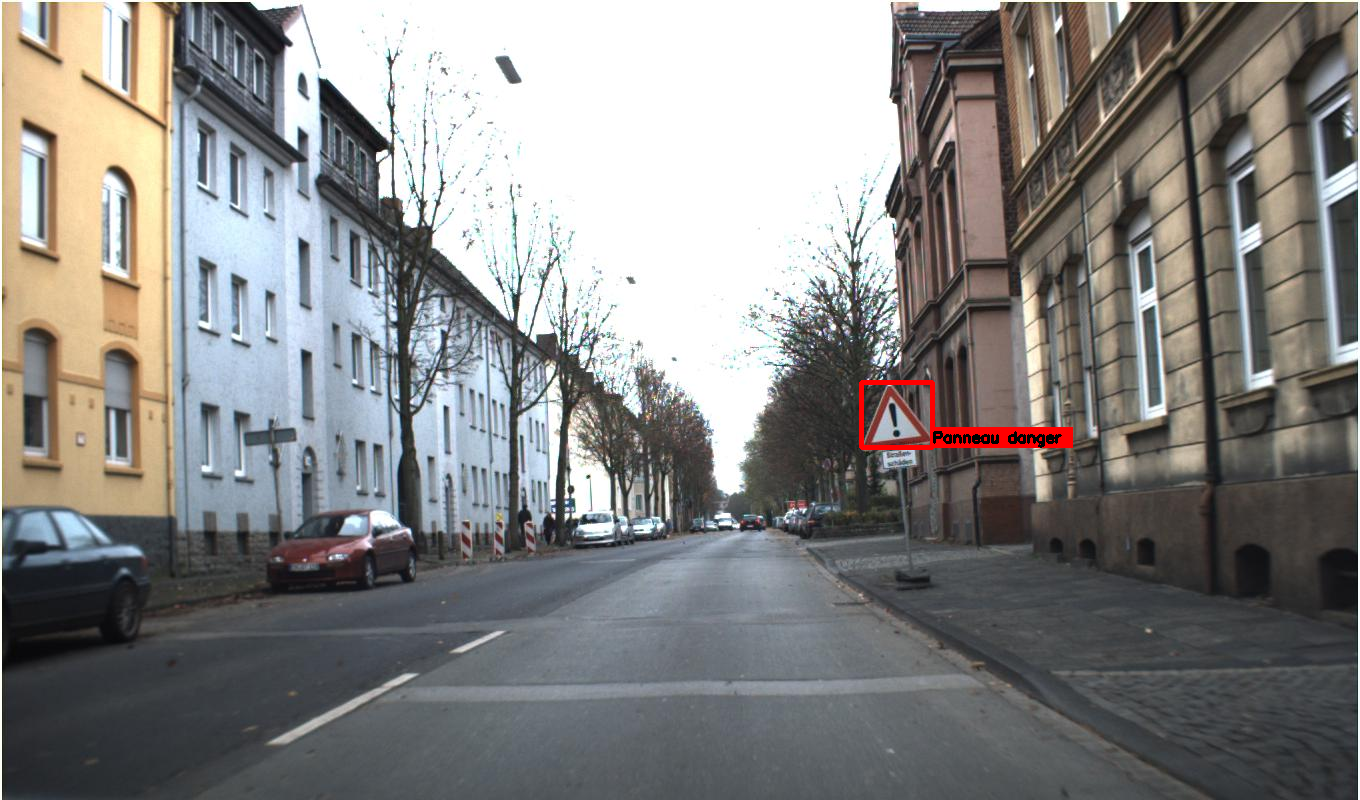

In [99]:
process_image('C:/Users/utilisateur/Desktop/Tutorial/models/research/object_detection/images/test/00828.jpeg')

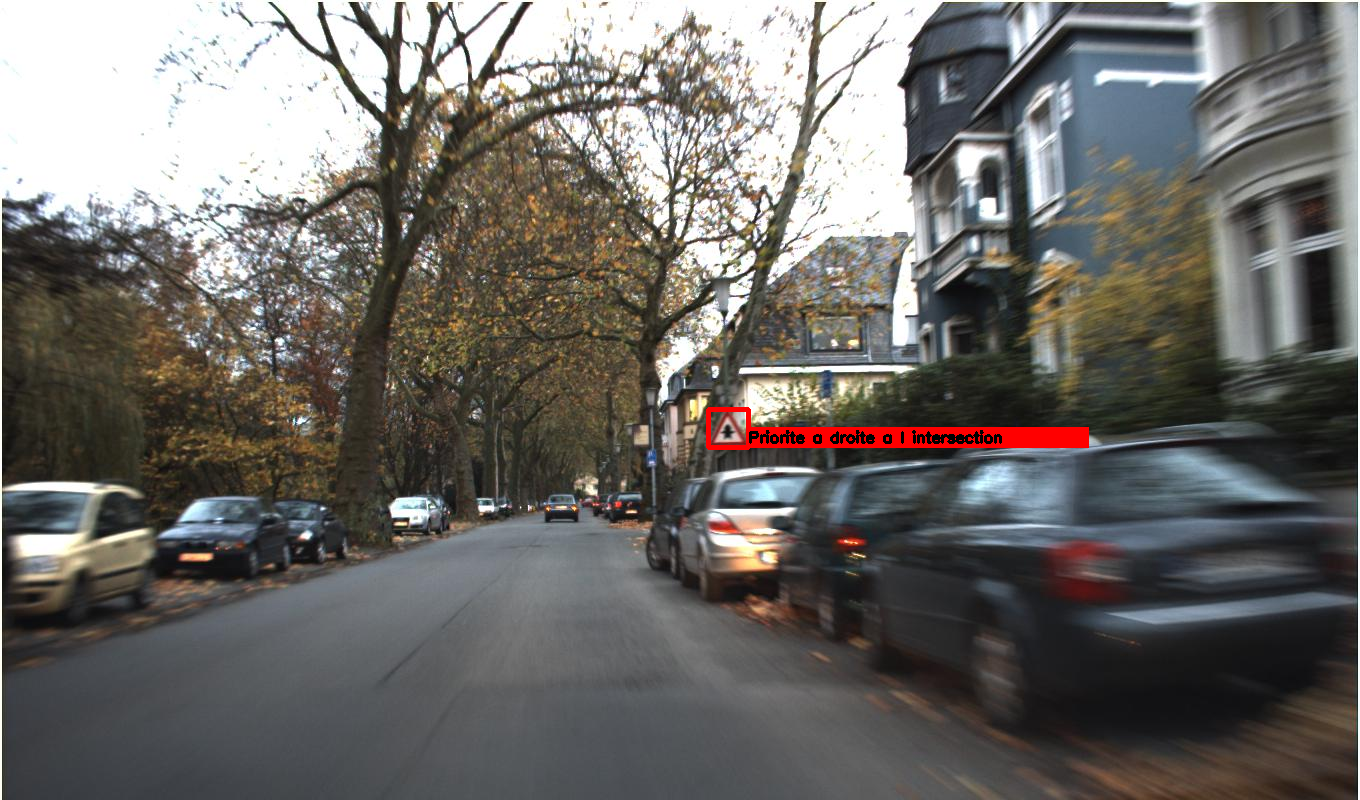

In [97]:
process_image('C:/Users/utilisateur/Desktop/Tutorial/models/research/object_detection/images/test/00817.jpeg')